# Advanced Machine Learning Techniques

## Agenda

1. Reading in the Kaggle data and adding features
2. Using a **`Pipeline`** for proper cross-validation
3. Combining **`GridSearchCV`** with **`Pipeline`**
4. Efficiently searching for tuning parameters using **`RandomizedSearchCV`**
5. Adding features to a document-term matrix (using SciPy)
6. Adding features to a document-term matrix (using **`FeatureUnion`**)
7. Ensembling models
8. Locating groups of similar cuisines
9. Model stacking

In [1]:
# for Python 2: use print only as a function
from __future__ import print_function

## Part 1: Reading in the Kaggle data and adding features

- Our goal is to predict the **cuisine** of a recipe, given its **ingredients**.
- **Feature engineering** is the process through which you create features that don't natively exist in the dataset.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
# define a function that accepts a DataFrame and adds new features
def make_features(df):
    
    # number of ingredients
    df['num_ingredients'] = df.ingredients.apply(len)
    
    # mean length of ingredient names
    df['ingredient_length'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    
    # string representation of the ingredient list
    df['ingredients_str'] = df.ingredients.astype(str)
    
    return df

In [4]:
# create the same features in the training data and the new data
train = make_features(pd.read_json('../data/train.json'))
new = make_features(pd.read_json('../data/test.json'))

In [5]:
train.head()

,id,cuisine,ingredients,num_ingredients,ingredient_length,ingredients_str
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000,"['romaine lettuce', 'black olives', 'grape tom..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909,"['plain flour', 'ground pepper', 'salt', 'toma..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki..."
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000,"['water', 'vegetable oil', 'wheat', 'salt']"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000,"['black pepper', 'shallots', 'cornflour', 'cay..."


In [6]:
train.shape

(39774, 6)

In [7]:
train.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

**We need to have same features in test-set as in train-set except target**

In [8]:
new.head()

,id,ingredients,num_ingredients,ingredient_length,ingredients_str
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",6,9.333333,"['baking powder', 'eggs', 'all-purpose flour',..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",11,10.272727,"['sugar', 'egg yolks', 'corn starch', 'cream o..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",6,9.666667,"['sausage links', 'fennel bulb', 'fronds', 'ol..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",21,12.000000,"['meat cuts', 'file powder', 'smoked sausage',..."
4,35687,"[ground black pepper, salt, sausage casings, l...",8,13.000000,"['ground black pepper', 'salt', 'sausage casin..."


In [9]:
new.shape

(9944, 5)

## Part 2: Using a `Pipeline` for proper cross-validation

In [10]:
# define X and y
X = train.ingredients_str
y = train.cuisine

In [11]:
# X is just a Series of strings
X.head()

0    ['romaine lettuce', 'black olives', 'grape tom...
1    ['plain flour', 'ground pepper', 'salt', 'toma...
2    ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...
3          ['water', 'vegetable oil', 'wheat', 'salt']
4    ['black pepper', 'shallots', 'cornflour', 'cay...
Name: ingredients_str, dtype: object

In [12]:
# replace the regex pattern that is used for tokenization
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(token_pattern=r"'([a-z ]+)'")

In [13]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

[make_pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

In [14]:
# create a pipeline of vectorization and Naive Bayes
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(vect, nb)

In [15]:
# examine the pipeline steps
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
                  vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

**Proper cross-validation:**

- By passing our pipeline to **`cross_val_score`**, features will be created from **`X`** (via **`CountVectorizer`**) within each fold of cross-validation.
- This process simulates the real world, in which your out-of-sample data will contain **features that were not seen** during model training.

In [16]:
# cross-validate the entire pipeline
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.7322884933790151

## Part 3: Combining `GridSearchCV` with `Pipeline`

- We use **`GridSearchCV`** to locate optimal tuning parameters by performing an "exhaustive grid search" of different parameter combinations, searching for the combination that has the best cross-validated accuracy.
- By passing a **`Pipeline`** to **`GridSearchCV`** (instead of just a model), we can search tuning parameters for both the vectorizer and the model.

In [17]:
# pipeline steps are automatically assigned names by make_pipeline
pipe.named_steps.keys()

dict_keys(['countvectorizer', 'multinomialnb'])

In [18]:
# create a grid of parameters to search (and specify the pipeline step along with the parameter)
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['multinomialnb__alpha'] = [0.5, 1]
param_grid

{'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"],
 'multinomialnb__alpha': [0.5, 1]}

[GridSearchCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html)

In [19]:
# pass the pipeline (instead of the model) to GridSearchCV
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [20]:
# time the grid search
%time grid.fit(X, y)

CPU times: user 34.4 s, sys: 494 ms, total: 34.8 s
Wall time: 16.1 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('countvectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                 

In [21]:
grid.cv_results_

{'mean_fit_time': array([0.68571405, 0.73354559, 0.53802452, 0.53402543]),
 'std_fit_time': array([0.04993944, 0.0264956 , 0.02710726, 0.04987582]),
 'mean_score_time': array([0.15376539, 0.15582905, 0.10774155, 0.10062079]),
 'std_score_time': array([0.01728257, 0.00947986, 0.01431289, 0.00574068]),
 'param_countvectorizer__token_pattern': masked_array(data=['\\b\\w\\w+\\b', '\\b\\w\\w+\\b', "'([a-z ]+)'",
                    "'([a-z ]+)'"],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_multinomialnb__alpha': masked_array(data=[0.5, 1, 0.5, 1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'countvectorizer__token_pattern': '\\b\\w\\w+\\b',
   'multinomialnb__alpha': 0.5},
  {'countvectorizer__token_pattern': '\\b\\w\\w+\\b',
   'multinomialnb__alpha': 1},
  {'countvectorizer__token_pattern': "'([a-z ]+)'",
   'multinomialnb__alpha': 0.5},
  {'countvectoriz

In [22]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print(grid.best_params_)

0.7476995021873586
{'countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.5}


## Part 4: Efficiently searching for tuning parameters using `RandomizedSearchCV`

- When there are many parameters to tune, searching all possible combinations of parameter values may be **computationally infeasible**.
- **`RandomizedSearchCV`** searches a sample of the parameter values, and you control the computational "budget".

[RandomizedSearchCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html)

In [23]:
from sklearn.model_selection import RandomizedSearchCV

[scipy.stats documentation](http://docs.scipy.org/doc/scipy/reference/stats.html)

In [24]:
# for any continuous parameters, specify a distribution instead of a list of options
import scipy as sp
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['countvectorizer__min_df'] = [1, 2, 3]
param_grid['multinomialnb__alpha'] = sp.stats.uniform(scale=1)
param_grid

{'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"],
 'countvectorizer__min_df': [1, 2, 3],
 'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x110da3250>}

In [25]:
# set a random seed for sp.stats.uniform
np.random.seed(1)

In [26]:
# additional parameters are n_iter (number of searches) and random_state
rand = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)

In [27]:
# time the randomized search
%time rand.fit(X, y)

CPU times: user 40.2 s, sys: 519 ms, total: 40.7 s
Wall time: 18.8 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('countvectorizer',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                               

In [28]:
print(rand.best_score_)
print(rand.best_params_)

0.745436717453613
{'countvectorizer__min_df': 2, 'countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.7203244934421581}


### Making predictions for new data

In [29]:
# define X_new as the ingredient text
X_new = new.ingredients_str

In [30]:
# print the best model found by RandomizedSearchCV
rand.best_estimator_

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern="'([a-z ]+)'", tokenizer=None,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=0.7203244934421581, class_prior=None,
                               fit_prior=True))],
         verbose=False)

In [31]:
# RandomizedSearchCV/GridSearchCV automatically refit the best model with the entire dataset, and can be used to make predictions
new_pred_class_rand = rand.predict(X_new)
new_pred_class_rand

array(['southern_us', 'southern_us', 'italian', ..., 'italian',
       'southern_us', 'mexican'], dtype='<U12')

In [32]:
# create a submission file (score: 0.75342)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_rand}).set_index('id').to_csv('submission.csv')

## Part 5: Adding features to a document-term matrix (using SciPy)

- So far, we've trained models on either the **document-term matrix** or the **manually created features**, but not both.
- To train a model on both types of features, we need to **combine them into a single feature matrix**.
- Because one of the matrices is **sparse** and the other is **dense**, the easiest way to combine them is by using SciPy.

In [33]:
# create a document-term matrix from all of the training data
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [34]:
type(X_dtm)

scipy.sparse.csr.csr_matrix

[scipy.sparse documentation](http://docs.scipy.org/doc/scipy/reference/sparse.html)

In [35]:
# create a DataFrame of the manually created features
X_manual = train.loc[:, ['num_ingredients', 'ingredient_length']]
X_manual.shape

(39774, 2)

In [36]:
# create a sparse matrix from the DataFrame
X_manual_sparse = sp.sparse.csr_matrix(X_manual)
type(X_manual_sparse)

scipy.sparse.csr.csr_matrix

In [37]:
# combine the two sparse matrices
X_dtm_manual = sp.sparse.hstack([X_dtm, X_manual_sparse])
X_dtm_manual.shape

(39774, 6252)

- This was a relatively easy process.
- However, it does not allow us to do **proper cross-validation**, and it doesn't integrate well with the rest of the **scikit-learn workflow**.

## Part 6: Adding features to a document-term matrix (using `FeatureUnion`)

- Below is an alternative process that does allow for proper cross-validation, and does integrate well with the scikit-learn workflow.
- To use this process, we have to learn about transformers, **`FunctionTransformer`**, and **`FeatureUnion`**.

### What are "transformers"?

Transformer objects provide a `transform` method in order to perform **data transformations**. Here are a few examples:

- **`CountVectorizer`**
    - `fit` learns the vocabulary
    - `transform` creates a document-term matrix using the vocabulary
- **`Imputer`**
    - `fit` learns the value to impute
    - `transform` fills in missing entries using the imputation value
- **`StandardScaler`**
    - `fit` learns the mean and scale of each feature
    - `transform` standardizes the features using the mean and scale
- **`HashingVectorizer`**
    - `fit` is not used, and thus it is known as a "stateless" transformer
    - `transform` creates the document-term matrix using a hash of the token

### Converting a function into a transformer

In [38]:
# define a function that accepts a DataFrame returns the manually created features
def get_manual(df):
    return df.loc[:, ['num_ingredients', 'ingredient_length']]

In [39]:
get_manual(train).head()

,num_ingredients,ingredient_length
0,9,12.000000
1,11,10.090909
2,12,10.333333
3,4,6.750000
4,20,10.100000


[FunctionTransformer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) (new in 0.17)

In [40]:
from sklearn.preprocessing import FunctionTransformer

In [41]:
# create a stateless transformer from the get_manual function
get_manual_ft = FunctionTransformer(get_manual, validate=False)
type(get_manual_ft)

sklearn.preprocessing._function_transformer.FunctionTransformer

In [42]:
# execute the function using the transform method
get_manual_ft.transform(train).head()

,num_ingredients,ingredient_length
0,9,12.000000
1,11,10.090909
2,12,10.333333
3,4,6.750000
4,20,10.100000


In [43]:
# define a function that accepts a DataFrame returns the ingredients string
def get_text(df):
    return df.ingredients_str

In [44]:
# create and test another transformer
get_text_ft = FunctionTransformer(get_text, validate=False)
get_text_ft.transform(train).head()

0    ['romaine lettuce', 'black olives', 'grape tom...
1    ['plain flour', 'ground pepper', 'salt', 'toma...
2    ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...
3          ['water', 'vegetable oil', 'wheat', 'salt']
4    ['black pepper', 'shallots', 'cornflour', 'cay...
Name: ingredients_str, dtype: object

### Combining feature extraction steps

- **`FeatureUnion`** applies a list of transformers in parallel to the input data (not sequentially), then **concatenates the results**.
- This is useful for combining several feature extraction mechanisms into a single transformer.

![Pipeline versus FeatureUnion](06_pipeline_versus_featureunion.jpg)

[make_union documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_union.html)

In [45]:
from sklearn.pipeline import make_union

In [46]:
# create a document-term matrix from all of the training data
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [47]:
# this is identical to a FeatureUnion with just one transformer
union = make_union(vect)
X_dtm = union.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [48]:
# try to add a second transformer to the Feature Union (what's wrong with this?)
# union = make_union(vect, get_manual_ft)
# X_dtm_manual = union.fit_transform(X)

In [49]:
# properly combine the transformers into a FeatureUnion
union = make_union(make_pipeline(get_text_ft, vect), get_manual_ft)
X_dtm_manual = union.fit_transform(train)
X_dtm_manual.shape

(39774, 6252)

![Pipeline in a FeatureUnion](06_pipeline_in_a_featureunion.jpg)

### Cross-validation

In [50]:
# slightly improper cross-validation
cross_val_score(nb, X_dtm_manual, y, cv=5, scoring='accuracy').mean()

0.7102895106852953

In [51]:
# create a pipeline of the FeatureUnion and Naive Bayes
pipe = make_pipeline(union, nb)

In [52]:
# properly cross-validate the entire pipeline (and pass it the entire DataFrame)
cross_val_score(pipe, train, y, cv=5, scoring='accuracy').mean()

0.7134318388611878

### Alternative way to specify `Pipeline` and `FeatureUnion`

In [53]:
# reminder of how we created the pipeline
union = make_union(make_pipeline(get_text_ft, vect), get_manual_ft)
pipe = make_pipeline(union, nb)

[Pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [FeatureUnion documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)

In [54]:
# duplicate the pipeline structure without using make_pipeline or make_union
from sklearn.pipeline import Pipeline, FeatureUnion
pipe = Pipeline([
    ('featureunion', FeatureUnion([
            ('pipeline', Pipeline([
                    ('functiontransformer', get_text_ft),
                    ('countvectorizer', vect)
                    ])),
            ('functiontransformer', get_manual_ft)
        ])),
    ('multinomialnb', nb)
])

### Grid search of a nested `Pipeline`

In [55]:
# examine the pipeline steps
pipe.steps

[('featureunion', FeatureUnion(n_jobs=None,
               transformer_list=[('pipeline',
                                  Pipeline(memory=None,
                                           steps=[('functiontransformer',
                                                   FunctionTransformer(accept_sparse=False,
                                                                       check_inverse=True,
                                                                       func=<function get_text at 0x1a2707e320>,
                                                                       inv_kw_args=None,
                                                                       inverse_func=None,
                                                                       kw_args=None,
                                                                       pass_y='deprecated',
                                                                       validate=False)),
                                       

In [56]:
# create a grid of parameters to search (and specify the pipeline step along with the parameter)
param_grid = {}
param_grid['featureunion__pipeline__countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['multinomialnb__alpha'] = [0.5, 1]
param_grid

{'featureunion__pipeline__countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
  "'([a-z ]+)'"],
 'multinomialnb__alpha': [0.5, 1]}

In [57]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [58]:
%time grid.fit(train, y)

CPU times: user 54.3 s, sys: 877 ms, total: 55.1 s
Wall time: 15.9 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('featureunion',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('functiontransformer',
                                                                                         FunctionTransformer(accept_sparse=False,
                                                                                                             check_inverse=True,
                                                                                                             func=<function get_text at 0x1a2707e320>,
                                                                                 

In [59]:
print(grid.best_score_)
print(grid.best_params_)

0.7426710916679238
{'featureunion__pipeline__countvectorizer__token_pattern': "'([a-z ]+)'", 'multinomialnb__alpha': 0.5}


## Part 7: Ensembling models

Rather than combining features into a single feature matrix and training a single model, we can instead create separate models and "ensemble" them.

### What is ensembling?

Ensemble learning (or "ensembling") is the process of combining several predictive models in order to produce a combined model that is **better than any individual model**.

- **Regression:** average the predictions made by the individual models
- **Classification:** let the models "vote" and use the most common prediction, or average the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different "processes", such as:
    - different types of models
    - different features
    - different tuning parameters

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

**Note:** There are also models that have built-in ensembling, such as Random Forests.

### Model 1: KNN model using only manually created features

In [60]:
# define X and y
feature_cols = ['num_ingredients', 'ingredient_length']
X = train[feature_cols]
y = train.cuisine

In [61]:
# use KNN with K=800
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=800)

In [62]:
# train KNN on all of the training data
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=800, p=2,
                     weights='uniform')

In [63]:
# define X_new as the manually created features
X_new = new[feature_cols]

In [64]:
# calculate predicted probabilities of class membership for the new data
new_pred_prob_knn = knn.predict_proba(X_new)
new_pred_prob_knn.shape

(9944, 20)

In [65]:
# print predicted probabilities for the first row only
new_pred_prob_knn[0, :]

array([0.02625, 0.0275 , 0.01375, 0.04375, 0.03375, 0.08   , 0.0175 ,
       0.075  , 0.0275 , 0.135  , 0.01   , 0.075  , 0.01875, 0.165  ,
       0.00875, 0.0125 , 0.1525 , 0.025  , 0.0275 , 0.025  ])

In [66]:
# display classes with probabilities
zip(knn.classes_, new_pred_prob_knn[0, :])

In [67]:
# predicted probabilities will sum to 1 for each row
new_pred_prob_knn[0, :].sum()

1.0

### Model 2: Naive Bayes model using only text features

In [68]:
# print the best model found by RandomizedSearchCV
rand.best_estimator_

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern="'([a-z ]+)'", tokenizer=None,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=0.7203244934421581, class_prior=None,
                               fit_prior=True))],
         verbose=False)

In [69]:
# define X_new as the ingredient text
X_new = new.ingredients_str

In [70]:
# calculate predicted probabilities of class membership for the new data
new_pred_prob_rand = rand.predict_proba(X_new)
new_pred_prob_rand.shape

(9944, 20)

In [71]:
# print predicted probabilities for the first row only
new_pred_prob_rand[0, :]

array([3.59476986e-04, 4.04209227e-01, 7.38375500e-05, 1.29657196e-04,
       3.00331358e-03, 2.09215451e-03, 4.82924358e-04, 5.35343905e-04,
       1.22359513e-01, 7.08319855e-03, 2.06222706e-04, 7.18742744e-04,
       5.49904762e-06, 1.64352345e-03, 1.01157435e-05, 1.71202022e-02,
       4.39643190e-01, 3.21357119e-04, 1.84691815e-06, 6.53184216e-07])

### Ensembling models 1 and 2

In [72]:
# calculate the mean of the predicted probabilities for the first row
(new_pred_prob_knn[0, :] + new_pred_prob_rand[0, :]) / 2

array([0.01330474, 0.21585461, 0.00691192, 0.02193983, 0.01837666,
       0.04104608, 0.00899146, 0.03776767, 0.07492976, 0.0710416 ,
       0.00510311, 0.03785937, 0.00937775, 0.08332176, 0.00438006,
       0.0148101 , 0.2960716 , 0.01266068, 0.01375092, 0.01250033])

In [73]:
# calculate the mean of the predicted probabilities for all rows
new_pred_prob = pd.DataFrame((new_pred_prob_knn + new_pred_prob_rand) / 2, columns=knn.classes_)
new_pred_prob.head()

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,0.013305,0.215855,0.006912,0.02194,0.018377,0.041046,0.008991,0.037768,0.074930,0.071042,0.005103,0.037859,0.009378,0.083322,0.004380,0.014810,0.296072,0.012661,0.013751,0.012500
1,0.008752,0.011794,0.016875,0.04500,0.018143,0.024328,0.015625,0.046250,0.010630,0.070625,0.005626,0.027503,0.021875,0.066875,0.008125,0.008751,0.546973,0.007500,0.025625,0.013125
2,0.013627,0.009447,0.007219,0.02000,0.015059,0.045080,0.011783,0.029383,0.013628,0.449318,0.005651,0.038760,0.007505,0.080644,0.024697,0.008373,0.079388,0.112301,0.015626,0.012510
3,0.003125,0.004375,0.533750,0.03875,0.001875,0.023125,0.006250,0.075625,0.001250,0.051875,0.011875,0.008125,0.003125,0.107500,0.029375,0.001875,0.025000,0.007500,0.038125,0.027500
4,0.001877,0.009598,0.020083,0.02125,0.003126,0.045360,0.017502,0.013750,0.012539,0.640831,0.003754,0.007500,0.003750,0.083130,0.004377,0.003133,0.072734,0.018206,0.014375,0.003125


In [74]:
# for each row, find the column with the highest predicted probability
new_pred_class = new_pred_prob.apply(np.argmax, axis=1)
new_pred_class.head()

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


0     southern_us
1     southern_us
2         italian
3    cajun_creole
4         italian
dtype: object

In [75]:
# create a submission file (score: 0.75241)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class}).set_index('id').to_csv('submission4.csv')

**Note:** [VotingClassifier](http://scikit-learn.org/stable/modules/ensemble.html#votingclassifier) (new in 0.17) makes it easier to ensemble classifiers, though it is limited to the case in which all of the classifiers are fit to the same data.

## Part 8: Locating groups of similar cuisines

In [76]:
# for each cuisine, combine all of the recipes into a single string
cuisine_ingredients = train.groupby('cuisine').ingredients_str.sum()
cuisine_ingredients

cuisine
brazilian       ['ice cubes', 'club soda', 'white rum', 'lime'...
british         ['greek yogurt', 'lemon curd', 'confectioners ...
cajun_creole    ['herbs', 'lemon juice', 'fresh tomatoes', 'pa...
chinese         ['low sodium soy sauce', 'fresh ginger', 'dry ...
filipino        ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...
french          ['sugar', 'salt', 'fennel bulb', 'water', 'lem...
greek           ['romaine lettuce', 'black olives', 'grape tom...
indian          ['water', 'vegetable oil', 'wheat', 'salt']['b...
irish           ['cooking spray', 'salt', 'black pepper', 'yuk...
italian         ['sugar', 'pistachio nuts', 'white almond bark...
jamaican        ['plain flour', 'sugar', 'butter', 'eggs', 'fr...
japanese        ['sirloin', 'mirin', 'yellow onion', 'low sodi...
korean          ['jasmine rice', 'garlic', 'scallions', 'sugar...
mexican         ['olive oil', 'purple onion', 'fresh pineapple...
moroccan        ['ground cloves', 'whole nutmegs', 'ground gin...
ru

In [77]:
# examine the brazilian ingredients
cuisine_ingredients['brazilian'][0:500]

"['ice cubes', 'club soda', 'white rum', 'lime', 'turbinado']['eggs', 'hearts of palm', 'cilantro', 'coconut cream', 'flax seed meal', 'kosher salt', 'jalapeno chilies', 'garlic', 'cream cheese, soften', 'coconut oil', 'lime juice', 'crushed red pepper flakes', 'ground coriander', 'pepper', 'chicken breasts', 'coconut flour', 'onions']['sweetened condensed milk', 'butter', 'cocoa powder']['lime', 'crushed ice', 'simple syrup', 'cachaca']['sugar', 'corn starch', 'egg whites', 'boiling water', 'col"

In [78]:
# confirm that they match the brazilian recipes
train.loc[train.cuisine=='brazilian', 'ingredients_str'].head()

41     ['ice cubes', 'club soda', 'white rum', 'lime'...
380    ['eggs', 'hearts of palm', 'cilantro', 'coconu...
423    ['sweetened condensed milk', 'butter', 'cocoa ...
509    ['lime', 'crushed ice', 'simple syrup', 'cacha...
724    ['sugar', 'corn starch', 'egg whites', 'boilin...
Name: ingredients_str, dtype: object

In [79]:
# create a document-term matrix from cuisine_ingredients
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
cuisine_dtm = vect.fit_transform(cuisine_ingredients)
cuisine_dtm.shape

(20, 3010)

[How to calculate document similarity](http://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity/12128777#12128777) (Stack Overflow)

In [80]:
# calculate the cosine similarity between each cuisine and all other cuisines
from sklearn import metrics
cuisine_similarity = []
for idx in range(cuisine_dtm.shape[0]):
    similarity = metrics.pairwise.linear_kernel(cuisine_dtm[idx, :], cuisine_dtm).flatten()
    cuisine_similarity.append(similarity)

In [81]:
# convert the results to a DataFrame
cuisine_list = cuisine_ingredients.index
cuisine_similarity = pd.DataFrame(cuisine_similarity, index=cuisine_list, columns=cuisine_list)
cuisine_similarity

cuisine,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
cuisine,,,,,,,,,,,,,,,,,,,,
brazilian,1.000000,0.660232,0.742324,0.580756,0.769216,0.756392,0.695692,0.687271,0.665713,0.740527,0.778320,0.555601,0.571440,0.743736,0.669009,0.706087,0.743156,0.807694,0.685539,0.653801
british,0.660232,1.000000,0.591230,0.467640,0.631356,0.859609,0.562750,0.560349,0.926682,0.632618,0.662057,0.508296,0.447177,0.560446,0.543260,0.909551,0.911271,0.604000,0.445518,0.478901
cajun_creole,0.742324,0.591230,1.000000,0.605581,0.746151,0.708849,0.688391,0.618955,0.635197,0.738159,0.780897,0.532394,0.578645,0.724877,0.649831,0.657802,0.747480,0.803637,0.590103,0.605224
chinese,0.580756,0.467640,0.605581,1.000000,0.839803,0.540446,0.496090,0.553532,0.460746,0.555504,0.635953,0.835587,0.866828,0.561837,0.505655,0.521844,0.558514,0.603526,0.755813,0.817005
filipino,0.769216,0.631356,0.746151,0.839803,1.000000,0.682939,0.607436,0.655934,0.641010,0.670628,0.792723,0.748558,0.782623,0.678302,0.614984,0.697000,0.720368,0.727409,0.741512,0.806833
french,0.756392,0.859609,0.708849,0.540446,0.682939,1.000000,0.759936,0.624868,0.837384,0.835272,0.723225,0.540279,0.502205,0.666830,0.685384,0.881173,0.862062,0.817541,0.548375,0.570925
greek,0.695692,0.562750,0.688391,0.496090,0.607436,0.759936,1.000000,0.640297,0.583675,0.859270,0.681281,0.469465,0.479835,0.696644,0.769412,0.649530,0.641229,0.837448,0.519004,0.538683
indian,0.687271,0.560349,0.618955,0.553532,0.655934,0.624868,0.640297,1.000000,0.577338,0.616211,0.734926,0.567993,0.538853,0.708621,0.795271,0.607432,0.617278,0.678865,0.627460,0.605162
irish,0.665713,0.926682,0.635197,0.460746,0.641010,0.837384,0.583675,0.577338,1.000000,0.649878,0.680914,0.494762,0.458798,0.591718,0.563303,0.892428,0.902850,0.630921,0.449931,0.481712


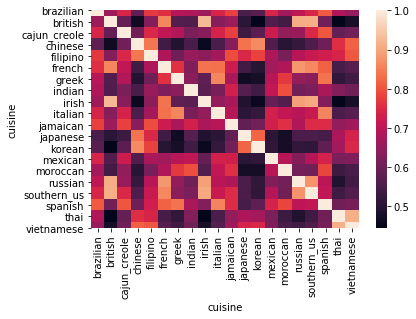

In [82]:
# display the similarities as a heatmap
%matplotlib inline
import seaborn as sns
sns.heatmap(cuisine_similarity)

In [83]:
# hand-selected cuisine groups
group_1 = ['chinese', 'filipino', 'japanese', 'korean', 'thai', 'vietnamese']
group_2 = ['british', 'french', 'irish', 'russian', 'southern_us']
group_3 = ['greek', 'italian', 'moroccan', 'spanish']
group_4 = ['brazilian', 'cajun_creole', 'indian', 'jamaican', 'mexican']

## Part 9: Model stacking

- The term "model stacking" is used any time there are **multiple "levels" of models**, in which the outputs from one level are used as inputs to another level.
- In this case, we will create one model that predicts the **cuisine group** for a recipe. Within each of the four groups, we will create another model that predicts the actual **cuisine**.
- Our theory is that each of these five models may need to be **tuned differently** for maximum accuracy, but will ultimately result in a process that is more accurate than a single-level model.

In [84]:
# create a dictionary that maps each cuisine to its group number
cuisines = group_1 + group_2 + group_3 + group_4
group_numbers = [1]*len(group_1) + [2]*len(group_2) + [3]*len(group_3) + [4]*len(group_4)
cuisine_to_group = dict(zip(cuisines, group_numbers))
cuisine_to_group

{'chinese': 1,
 'filipino': 1,
 'japanese': 1,
 'korean': 1,
 'thai': 1,
 'vietnamese': 1,
 'british': 2,
 'french': 2,
 'irish': 2,
 'russian': 2,
 'southern_us': 2,
 'greek': 3,
 'italian': 3,
 'moroccan': 3,
 'spanish': 3,
 'brazilian': 4,
 'cajun_creole': 4,
 'indian': 4,
 'jamaican': 4,
 'mexican': 4}

In [85]:
# map the cuisines to their group numbers
train['group'] = train.cuisine.map(cuisine_to_group)
train.head()

,id,cuisine,ingredients,num_ingredients,ingredient_length,ingredients_str,group
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000,"['romaine lettuce', 'black olives', 'grape tom...",3
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909,"['plain flour', 'ground pepper', 'salt', 'toma...",2
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...",1
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000,"['water', 'vegetable oil', 'wheat', 'salt']",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000,"['black pepper', 'shallots', 'cornflour', 'cay...",4


In [86]:
# confirm that all recipes were assigned a cuisine group
train.group.isnull().sum()

0

In [87]:
# calculate the cross-validated accuracy of using text to predict cuisine group
X = train.ingredients_str
y = train.group
pipe_main = make_pipeline(CountVectorizer(), MultinomialNB())
cross_val_score(pipe_main, X, y, cv=5, scoring='accuracy').mean()

0.8276513701245822

In [88]:
# define an X and y for each cuisine group
X1 = train.loc[train.group==1, 'ingredients_str']
y1 = train.loc[train.group==1, 'cuisine']
X2 = train.loc[train.group==2, 'ingredients_str']
y2 = train.loc[train.group==2, 'cuisine']
X3 = train.loc[train.group==3, 'ingredients_str']
y3 = train.loc[train.group==3, 'cuisine']
X4 = train.loc[train.group==4, 'ingredients_str']
y4 = train.loc[train.group==4, 'cuisine']

In [89]:
# define a pipeline for each cuisine group
pipe_1 = make_pipeline(CountVectorizer(), MultinomialNB())
pipe_2 = make_pipeline(CountVectorizer(), MultinomialNB())
pipe_3 = make_pipeline(CountVectorizer(), MultinomialNB())
pipe_4 = make_pipeline(CountVectorizer(), MultinomialNB())

In [90]:
# within each cuisine group, calculate the cross-validated accuracy of using text to predict cuisine
print(cross_val_score(pipe_1, X1, y1, cv=5, scoring='accuracy').mean())
print(cross_val_score(pipe_2, X2, y2, cv=5, scoring='accuracy').mean())
print(cross_val_score(pipe_3, X3, y3, cv=5, scoring='accuracy').mean())
print(cross_val_score(pipe_4, X4, y4, cv=5, scoring='accuracy').mean())

0.7693031228079263
0.7568885301219405
0.8701840957938736
0.9043403347972706


**Note:** Ideally, each of the five pipelines should be **individually tuned** from start to finish, including feature engineering, model selection, and parameter tuning.

### Making predictions for the new data

In [91]:
# fit each pipeline with the relevant X and y
pipe_main.fit(X, y)
pipe_1.fit(X1, y1)
pipe_2.fit(X2, y2)
pipe_3.fit(X3, y3)
pipe_4.fit(X4, y4)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [92]:
# for the new data, first make cuisine group predictions
X_new = new.ingredients_str
new_pred_group = pipe_main.predict(X_new)
new_pred_group

array([2, 2, 3, ..., 3, 4, 4])

In [93]:
# then within each predicted cuisine group, make cuisine predictions
new_pred_class_1 = pipe_1.predict(X_new[new_pred_group==1])
new_pred_class_2 = pipe_2.predict(X_new[new_pred_group==2])
new_pred_class_3 = pipe_3.predict(X_new[new_pred_group==3])
new_pred_class_4 = pipe_4.predict(X_new[new_pred_group==4])
print(new_pred_class_1)
print(new_pred_class_2)
print(new_pred_class_3)
print(new_pred_class_4)

['chinese' 'japanese' 'vietnamese' ... 'chinese' 'chinese' 'vietnamese']
['british' 'southern_us' 'southern_us' ... 'southern_us' 'french' 'french']
['spanish' 'italian' 'spanish' ... 'italian' 'italian' 'italian']
['cajun_creole' 'mexican' 'indian' ... 'mexican' 'cajun_creole' 'mexican']


In [94]:
# add the cuisine predictions to the DataFrame of new data
new.loc[new_pred_group==1, 'pred_class'] = new_pred_class_1
new.loc[new_pred_group==2, 'pred_class'] = new_pred_class_2
new.loc[new_pred_group==3, 'pred_class'] = new_pred_class_3
new.loc[new_pred_group==4, 'pred_class'] = new_pred_class_4

In [95]:
new.head()

,id,ingredients,num_ingredients,ingredient_length,ingredients_str,pred_class
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",6,9.333333,"['baking powder', 'eggs', 'all-purpose flour',...",british
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",11,10.272727,"['sugar', 'egg yolks', 'corn starch', 'cream o...",southern_us
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",6,9.666667,"['sausage links', 'fennel bulb', 'fronds', 'ol...",spanish
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",21,12.000000,"['meat cuts', 'file powder', 'smoked sausage',...",cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, l...",8,13.000000,"['ground black pepper', 'salt', 'sausage casin...",italian


In [96]:
# create a submission file (score: 0.70475)
pd.DataFrame({'id':new.id, 'cuisine':new.pred_class}).set_index('id').to_csv('submission5.csv')